# 11.뉴스 요약봇 만들기

## 13. 프로젝트: 뉴스기사 요약해보기
새로운 데이터셋에 대해서 추상적 요약과 추출적 요약을 모두 해보자.

### Step 1. 데이터 수집하기
---
데이터는 아래 링크에 있는 뉴스 기사 데이터(newssummarymore.csv)를 사용한다.<br>
[sunnysai12345/News_Summary](https://github.com/sunnysai12345/News_Summary)

아래의 코드로 데이터를 다운로드 할 수 있다.


In [1]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request

[nltk_data] Downloading package stopwords to /home/aiffel-
[nltk_data]     dj10/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [3]:
data.sample(10)

,headlines,text
67023,BHU tried suppressing incident of male student...,Police records have revealed that a male stude...
59786,Commercial cinema actresses taken for granted:...,Actress Jacqueline Fernandez has said that she...
14027,WhatsApp bug allowed account hacking with vide...,A bug in WhatsApp messaging service reportedly...
46811,'Housefull 4' is going to be like a 3-month va...,Akshay Kumar has said shooting for his film 'H...
72744,IIM-A develops matrimonial website for people ...,A team of researchers at the Indian Institute ...
87706,Samsung Galaxy S8 'airtight' iris scanner fool...,A hacking group has demonstrated how Samsung G...
44650,Karnataka government unveils official state flag,Karnataka CM Siddaramaiah on Thursday accepted...
25960,US cops use coin flip to decide woman's arrest,Two US police officers have been suspended aft...
22949,ICC trolls Kohli with a mic drop tweet after I...,The ICC trolled Indian captain Virat Kohli ove...
5833,"Tej Pratap announces 'return' to politics, ref...",RJD Chief Lalu Prasad Yadav's son Tej Pratap Y...


이 데이터는 기사의 본문에 해당되는 text와 headlines 두 가지 열로 구성되어져 있다.Text 열의 내용을 요약한 것이 Summary 열이다. 여기서는 인공 신경망을 통해 Text 시퀀스를 입력받으면, Summary 시퀀스를 예측하도록 인공 신경망을 훈련시킬 것이다.

추상적 요약을 하는 경우에는 text를 본문, headlines를 이미 요약된 데이터로 삼아서 모델을 학습할 수 있다. 추출적 요약을 하는 경우에는 오직 text열만을 사용하자.

### Step 2. 데이터 전처리하기 (추상적 요약)
---
실습에서 사용된 전처리를 참고하여 각자 필요하다고 생각하는 전처리를 추가 사용하여 텍스트를 정규화 또는 정제해보자. 만약, 불용어 제거를 선택한다면 상대적으로 길이가 짧은 요약 데이터에 대해서도 불용어를 제거하는 것이 좋을지 고민해보자.

#### 칼럼명 변경
---
참조: [rename()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.rename.html)

In [4]:
#pandas DataFrame의 칼럼 이름 바꾸기

data=data.rename(columns={'headlines':'Summary','text':'Text'})
data2 = data['Text']
data.head()

,Summary,Text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...


#### 중복 샘플과 NULL 값이 존재하는 샘플 제거
---
우선 데이터의 중복 샘플 유무를 확인해보자.

In [5]:
print('유니크한 Summary 수 :', data.Summary.nunique())
print('유니크한 Text 수 :', data.Text.nunique())

유니크한 Summary 수 : 98280
유니크한 Text 수 : 98360


중복을 제외한다면 headlines에는 98280개, text에는 98360개의 의 유니크한 데이터가 존재한다.

데이터프레임의 `drop_duplicates()`를 사용하면, 손쉽게 중복 샘플을 제거할 수 있다.

In [6]:
data.drop_duplicates(subset = ['Text'], inplace = True)
print('Text전체 샘플수 :',(len(data)))

Text전체 샘플수 : 98360


In [7]:
# data.drop_duplicates(subset = ['Summary'], inplace = True)
# print('headlines(Summary)전체 샘플수 :',(len(data)))

데이터프레임에 Null 값이 있는지 확인하는 방법은 `.isnull().sum()`을 사용하면 알아볼 수 있다.

In [8]:
print(data.isnull().sum())

Summary    0
Text       0
dtype: int64


#### 텍스트 정규화와 불용어 제거
---
이 사전은 아래의 링크에서 참고하여 만들었다. 정규화 사전 출처 : [ https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python](https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python)

In [9]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ",len(contractions))

정규화 사전의 수:  120


이제 정규화 준비까지 마쳤다.

하지만 아직 끝난게 아니다. 일반적으로 텍스트에는 자주 등장하지만 자연어 처리를 할 때 실질적으로 별 도움이 되지 않는 단어들이 존재한다. 이를 불용어(stopwords)라고 부른다. 때로는 불용어를 제거하는 것이 자연어 처리의 성능을 높이는 방법일 수 있다. 여기서는 NLTK에서 제공하는 불용어 리스트를 참조해, 샘플에서 불용어를 제거할 것이다.

In [10]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

불용어를 제거할것이다. 이 작업 외에도 모든 영어문자는 소문자로 만들고, 섞여있는 html 태그를 제거하고, 정규 표현식을 통해 각종 특수문자를 제거해서 정말 필요한 내용만 잘 학습할 수 있도록 처리할것이다.

함수의 하단을 보면, NLTK를 이용해 불용어를 제거하는 파트가 있는데, 이는 Text 전처리 시에서만 호출하고 이미 상대적으로 문장 길이가 짧은 Summary 전처리할 때는 호출하지 않을 예정이다. Abstractive한 문장 요약 결과문이 자연스러운 문장이 되려면 이 불용어들이 Summary에는 남아 있는게 더 좋을 것 같다. 이 처리를 위해서 함수의 인자로 remove_stopwords를 추가하고, if문을 추가했다.

In [11]:
#데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","",sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

전처리 전, 후의 결과를 확인하기 위해서 임의의 text와 summary를 만들어 함수를 호출해보자.

혹시 아래 코드가 오류가 난다면 parser가 설치되어있지 않은 것이니, lxml을 설치해야한다.

```bash
$ pip install lxml
```

In [12]:
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_summary = 'Great way to start (or finish) the day!!!'

print(preprocess_sentence(temp_text))
print(preprocess_sentence(temp_summary, False))  # 불용어를 제거하지 않습니다.

everything bought great infact ordered twice third ordered wasfor mother father
great way to start the day


결과를 보면 기본적으로 모든 알파벳이 소문자로 변환되고, __`<br/>`__과 같은 html 태그가 제거되었다. 또한 (or finish)와 같은 괄호로 묶였던 단어 시퀀스가 제거된 것도 확인할 수 있다. 그리고 특수문자가 제거되면서 영어만 남았다.

#### 훈련 데이터 전체 전처리
---
Text의 경우에는 불용어를 제거하고, Summary의 경우에는 불용어를 제거하지 않을 것이므로 따로 호출해서 진행해야한다. 먼저 Text를 전처리하고, 결과를 확인하기 위해서 상위 5개의 줄을 출력해보자.

In [13]:
clean_text = []

# 전체 Text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다. 
for s in data['Text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
clean_text[:5]

['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers',
 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit',
 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history',
 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insure critical il

이제 Summary에 대해서 전처리 함수를 호출해줄 때는, 불용어 제거를 수행하지 않는다는 의미에서 두번째 인자로 False를 넣어준다.

In [14]:
clean_summary = []

# 전체 Summary 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다. 
for s in data['Summary']:
    clean_summary.append(preprocess_sentence(s, False))

clean_summary[:5]

['upgrad learner switches to career in ml al with salary hike',
 'delhi techie wins free food from swiggy for one year on cred',
 'new zealand end rohit sharma led india match winning streak',
 'aegon life iterm insurance plan helps customers save tax',
 'have known hirani for yrs what if metoo claims are not true sonam']

정제 전에는 데이터가 존재했지만, 정제 과정에서 문장의 모든 단어가 사라지는 경우가 있을 수 있다. 이렇게 되면 샘플 자체가 빈 값을 가지게 된다.

보다 쉽게 확인하기 위해 데이터들을 데이터프레임에 재저장한다. 그리고 빈(empty) 값을 가진 샘플들이 있다면, 모두 Null 값을 가진 샘플로 대체한다.

In [15]:
data['Text'] = clean_text
data['Summary'] = clean_summary

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

이전과 같이 `.isnull().sum()`을 사용해서 Null 값이 생겼는지 확인하자.

In [16]:
data.isnull().sum()

Summary    0
Text       0
dtype: int64

###  데이터 전처리하기 (2) 훈련데이터와 테스트데이터 나누기
---
학습을 진행하기 위해서는 학습에 사용할 데이터의 크기를 결정하고, 문장의 시작과 끝을 표시 해줘야한다.

#### 샘플의 최대 길이 정하기
---
필요없는 단어를 모두 솎아낸 데이터를 가지게 되었으니, 이제 훈련에 사용할 샘플의 최대 길이를 정해줄 차례이다.

Text와 Summary의 최소, 최대, 평균 길이를 구하고 또한 길이 분포를 시각화해서 보자.


텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534


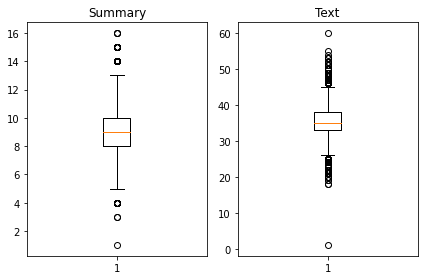

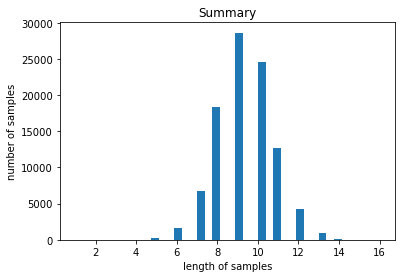

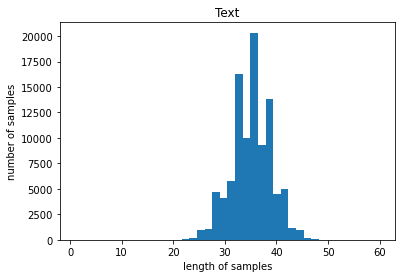

In [17]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['Text']]
summary_len = [len(s.split()) for s in data['Summary']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(summary_len)
plt.title('Summary')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('Text')
plt.tight_layout()
plt.show()

plt.title('Summary')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

#### Text의 최대 길이와 Summary의 적절한 최대 길이 정하기
---

In [18]:
text_max_len = 43
summary_max_len = 12

훈련 데이터와 샘플의 길이를 입력하면, 데이터의 몇 %가 해당하는지 계산하는 함수를 만들어서 좀 더 정확하게 판단해보자.

In [19]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s.split()) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [20]:
below_threshold_len(text_max_len, data['Text'])
below_threshold_len(summary_max_len,  data['Summary'])

전체 샘플 중 길이가 43 이하인 샘플의 비율: 0.9871797478649857
전체 샘플 중 길이가 12 이하인 샘플의 비율: 0.9880337535583571


#### 정해진 길이보다 길면 제외하는 방법으로 데이터를 정제해보자.
---

In [21]:
data = data[data['Text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['Summary'].apply(lambda x: len(x.split()) <= summary_max_len)]
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 95935


#### 시작 토큰과 종료 토큰 추가하기
---
디코더는 시작 토큰을 입력받아 문장을 생성하기 시작하고, 종료 토큰을 예측한 순간에 문장 생성을 멈추는 것이다.

<img src="./image/encoder_decoder.png" alt="시작 토큰과 종료 토큰" />

seq2seq 훈련을 위해서는 디코더의 입력과 레이블에 시작 토큰과 종료 토큰을 추가할 필요가 있다. 이번 실습에서는 시작 토큰은 'sostoken', 종료 토큰은 'eostoken'이라 임의로 명명하고 앞, 뒤로 추가할 것이다. 디코더의 입력에 해당하면서 시작 토큰이 맨 앞에 있는 문장의 이름을 decoder_input, 디코더의 출력 또는 레이블에 해당되면서 종료 토큰이 맨 뒤에 붙는 문장의 이름을 decoder_target이라고 이름을 정했다. 두 개의 문장 모두 Summary 열로부터 만들것이다.

In [22]:
#요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['Summary'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['Summary'].apply(lambda x : x + ' eostoken')
data.head()

,Summary,Text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...
6,india get all out for their lowest odi total i...,india recorded lowest odi total new zealand ge...,sostoken india get all out for their lowest od...,india get all out for their lowest odi total i...


앞뒤로 토큰이 잘 붙은 모습이다. 인코더의 입력, 디코더의 입력과 레이블을 각각 다시 Numpy 타입으로 저장해주자.

In [23]:
encoder_input = np.array(data['Text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

#### 훈련 데이터와 테스트 데이터를 분리
---
우선, encoder_input과 크기와 형태가 같은 순서가 섞인 정수 시퀀스를 만들어주자.

In [24]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[ 4348 45900 27118 ... 86635 66215 52402]


이 정수 시퀀스를 이용해 다시 데이터의 샘플 순서를 정의해주면 잘 섞인 샘플이 된다.

In [25]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

섞인 데이터를 8:2의 비율로 훈련 데이터와 테스트 데이터로 분리해주자. 전체 데이터의 크기에서 0.2를 곱해서 테스트 데이터의 크기를 정의해주면 된다

In [26]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :',n_of_val)

테스트 데이터의 수 : 19187


이렇게 정의한 테스트 데이터의 갯수를 이용해 전체 데이터를 양분하자. :표시의 위치에 주의해야한다.

In [27]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

훈련 데이터의 개수 : 76748
훈련 레이블의 개수 : 76748
테스트 데이터의 개수 : 19187
테스트 레이블의 개수 : 19187


### 7. 데이터 전처리하기 (3) 정수 인코딩
---

#### 단어 집합(vocaburary) 만들기 및 정수 인코딩
---
이제 기계가 텍스트를 숫자로 처리할 수 있도록 훈련 데이터와 테스트 데이터의 단어들을 모두 정수로 바꾸어 주어야한다. 이를 위해서는 각 단어에 고유한 정수를 맵핑하는 작업이 필요하다. 이 과정을 __단어 집합(vocaburary)__을 만든다고 표현한다. 훈련 데이터에 대해서 단어 집합을 만들어보자. 우선, 원문에 해당되는 `encoder_input_train`에 대해서 단어 집합을 만들자.

Keras의 토크나이저를 사용하면, 입력된 훈련 데이터로부터 단어 집합을 만들 수 있다.

In [28]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

이제 단어 집합이 생성되는 동시에 각 단어에 고유한 정수가 부여되었다. 현재 생성된 단어 집합은 `src_tokenizer.word_index`에 저장되어있다. 그런데 이렇게 만든 단어 집합에 있는 모든 단어를 사용하는 것이 아니라, 빈도수가 낮은 단어들은 훈련 데이터에서 제외하고 진행하려고 한다.

등장 빈도수가 7회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인해보자.

`src_tokenizer.word_counts.items()`에는 단어와 각 단어의 등장 빈도수가 저장되어져 있는데, 이를 통해서 통계적인 정보를 얻을 수 있다.

In [29]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 68559
등장 빈도가 6번 이하인 희귀 단어의 수: 46705
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 21854
단어 집합에서 희귀 단어의 비율: 68.1238057731297
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.5355781306565004


등장 빈도가 threshold 값인 7회 미만, 즉, 6회 이하인 단어들은 단어 집합에서 무려 65% 이상을 차지한다. 하지만, 실제로 훈련 데이터에서 등장 빈도로 차지하는 비중은 상대적으로 적은 수치인 3.5%밖에 되지 않는다.

그래서 등장 빈도가 6회 이하인 단어들은 정수 인코딩 과정에서 빼고, 훈련 데이터에서 제거하고자 한다. 이를 제외한 단어 집합의 크기를 21796로 제한해보자. 토크나이저를 정의할 때 num_words의 값을 정해주면, 단어 집합의 크기를 제한할 수 있다.

In [30]:
src_vocab = 21796
src_tokenizer = Tokenizer(num_words = src_vocab) # 단어 집합의 크기를 21796으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성.

`texts_to_sequences()`는 생성된 단어 집합에 기반하여 입력으로 주어진 텍스트 데이터의 단어들을 모두 정수로 변환하는 정수 인코딩을 수행한다. 현재 단어 집합의 크기를 8,000으로 제한했으니 이제 8,000이 넘는 숫자들은 정수 인코딩 후에는 데이터에 존재하지 않는다.

In [31]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

#잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[447, 81, 2720, 250, 7346, 2, 55, 193, 1, 82, 16473, 2671, 2393, 360, 250, 712, 74, 237, 110, 35, 706, 3605, 498, 265, 154, 4862, 4, 2720, 1979, 2617, 2, 29, 3, 390, 479, 733, 250, 712], [4344, 1255, 315, 7, 64, 320, 1452, 84, 1740, 7987, 112, 2, 776, 136, 586, 584, 699, 91, 61, 4344, 6, 2057, 199, 1361, 7987, 51, 1687, 1740, 7987, 184, 88, 90, 148, 106, 232, 87], [274, 16, 1150, 3628, 55, 248, 5, 449, 430, 1524, 5213, 39, 350, 207, 17, 3062, 2253, 283, 575, 9894, 1150, 1547, 224, 365, 5, 6222, 105, 496, 136, 105, 1066, 1765, 4443, 105, 5373, 107, 2253]]


Summary 데이터에 대해서도 동일한 작업을 수행해보자. 케라스의 토크나이저를 사용하여 `decoder_input_train`을 입력으로 전체 단어 집합과 각 단어에 대한 빈도수를 계산한다.

In [32]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

이제 단어 집합이 생성되는 동시에 각 단어에 고유한 정수가 부여되었다. 이는 `tar_tokenizer.word_index`에 저장되어있다. `tar_tokenizer.word_counts.items()`에는 단어와 각 단어의 등장 빈도수가 저장되어져 있는데, 이를 통해서 통계적인 정보를 얻어서, 등장 빈도수가 6회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인해보자.

In [33]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 29752
등장 빈도가 5번 이하인 희귀 단어의 수: 19468
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10284
단어 집합에서 희귀 단어의 비율: 65.43425652057005
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.753240383674641


등장 빈도가 5회 이하인 단어들은 단어 집합에서 약 65%를 차지하고있다. 하지만, 실제로 훈련 데이터에서 등장 빈도로 차지하는 비중은 상대적으로 매우 적은 수치인 4.71%밖에 되지 않는다. 아까 했던것과 동일하게 이 단어들은 모두 제거하자.

In [34]:
tar_vocab = 10000
tar_tokenizer = Tokenizer(num_words = tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

#잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 290, 11, 543, 336, 24, 757, 239, 55, 20, 2849, 10, 235], [1, 2306, 216, 104, 88, 901, 16, 8, 491, 927], [1, 24, 11, 275, 25, 659, 131, 5126, 6, 4318, 59, 645, 14], [1, 995, 1524, 136, 223, 1875, 3, 2307, 3, 56, 3723], [1, 443, 180, 2973, 537, 673, 5, 37, 54]]
target
decoder  [[290, 11, 543, 336, 24, 757, 239, 55, 20, 2849, 10, 235, 2], [2306, 216, 104, 88, 901, 16, 8, 491, 927, 2], [24, 11, 275, 25, 659, 131, 5126, 6, 4318, 59, 645, 14, 2], [995, 1524, 136, 223, 1875, 3, 2307, 3, 56, 3723, 2], [443, 180, 2973, 537, 673, 5, 37, 54, 2]]


정상적으로 정수 인코딩 작업이 끝났다. 현재 `decoder_input_train`과 `decoder_target_train`에는 더 이상 숫자 2,000이 넘는 숫자들은 존재하지 않는다. 그런데 다음 작업인 패딩하기로 넘어가기 전에 한 가지 점검해야할 것이 있다.

전체 데이터에서 빈도수가 낮은 단어가 삭제되었다는 것은 빈도수가 낮은 단어만으로 구성되었던 샘플들은 이제 빈(empty) 샘플이 되었을 가능성이 있다. 이 현상은 길이가 상대적으로 길었던 원문(Text)의 경우에는 문제가 별로 없겠지만, 애초에 평균 길이가 4밖에 되지 않았던 요약문(Summary)의 경우에는 이 현상이 굉장히 두드러졌을 가능성이 높을 것이다.

요약문에서 길이가 0이 된 샘플들의 인덱스를 받아와보자. 여기서 주의할 점은 요약문인 `decoder_input`에는 `sostoken` 또는 `decoder_target`에는 `eostoken`이 추가된 상태이고, 이 두 토큰은 모든 샘플에서 등장하므로 빈도수가 샘플수와 동일하게 매우 높으므로 단어 집합 제한에도 삭제 되지 않는다. 그래서 이제 길이가 0이 된 요약문의 실제길이는 1로 나올것이다. 길이 0이 된 `decoder_input`에는 `sostoken`, `decoder_target`에는 `eostoken`만 남아 있을 것이기 때문이다.

훈련 데이터와 테스트 데이터에 대해서 요약문의 길이가 1인 경우의 인덱스를 각각 `drop_train`과 `drop_test`에 라는 변수에 저장해보자. 이 샘플들은 모두 삭제할 것이다.

In [35]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :',len(drop_train))
print('삭제할 테스트 데이터의 개수 :',len(drop_test))

encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

encoder_input_test = np.delete(encoder_input_test, drop_test, axis=0)
decoder_input_test = np.delete(decoder_input_test, drop_test, axis=0)
decoder_target_test = np.delete(decoder_target_test, drop_test, axis=0)

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 1
훈련 데이터의 개수 : 76748
훈련 레이블의 개수 : 76748
테스트 데이터의 개수 : 19186
테스트 레이블의 개수 : 19186


/home/aiffel-dj10/anaconda3/envs/aiffel/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


#### 패딩하기
---
텍스트 시퀀스를 정수 시퀀스로 변환했다면, 이제 서로 다른 길이의 샘플들을 병렬 처리하기 위해 같은 길이로 맞춰주는 패딩 작업을 해주어야한다. 아까 정해두었던 최대 길이로 패딩해 줄 것이다. 최대 길이보다 짧은 데이터들은 뒤의 공간에 숫자 0을 넣어 최대 길이로 길이를 맞춰주자.

In [36]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen = text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen = text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen = summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen = summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen = summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen = summary_max_len, padding='post')

### Step 3. 어텐션 메커니즘 사용하기 (추상적 요약)
---
일반적인 seq2seq보다는 어텐션 메커니즘을 사용한 seq2seq를 사용하는 것이 더 나은 성능을 얻을 수 있다. 어텐션 메커니즘을 사용한 seq2seq를 설계해보자.

#### 8. 모델 설계하기
---
이제 모델을 설계할 시간이다. 우선 함수형 API를 이용해서 인코더를 설계해보자.

In [37]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

임베딩 벡터의 차원은 128로 정의하고, hidden state의 크기를 256으로 정의했다. hidden state는 LSTM에서 얼만큼의 수용력(capacity)를 가질지를 정하는 파라미터이다. 이 파라미터는 LSTM의 용량의 크기나, LSTM에서의 뉴론의 갯수라고 이해하면 된다. 다른 신경망과 마찬가지로, 무조건 용량을 많이 준다고 해서 성능이 반드시 올라가는 것은 아니다.

인코더의 LSTM은 총 3개의 층으로 구성해서 모델의 복잡도를 높였다. hidden state의 크기를 늘리는 것이 LSTM 층 1개의 용량을 늘린다면, 3개의 층을 사용하는 것은 모델의 용량을 늘린다고 볼 수 있다. 3개의 층을 지나서 인코더로부터 나온 출력 벡터는 디코더로 보내줘야 할 것이다.

디코더를 설계해보자.

In [38]:
# 디코더 설계

decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences = True, return_state = True, dropout = 0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state = [state_h, state_c])

디코더의 임베딩 층과 LSTM을 설계하는 것은 인코더와 거의 동일하다. 하지만 LSTM의 입력을 정의할 때, initial_state의 인자값으로 인코더의 hidden state와 cell state의 값을 넣어줘야 한다.

디코더의 출력층을 설계해보자.

In [39]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation = 'softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 43)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 43, 128)      2789888     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 43, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

디코더의 출력층에서는 Summary의 단어장인 `tar_vocab`의 수많은 선택지 중 하나의 단어를 선택하는 다중 클래스 분류 문제를 풀어야한다. 그렇기 때문에 Dense의 인자로 `tar_vocab`을 주고, 활성화 함수로 소프트맥스 함수를 사용하고 있다.

지금까지 설계한 것은 인코더의 hidden state와 cell state를 디코더의 초기 state로 사용하는 가장 기본적인 seq2seq이다. 그런데 디코더의 출력층을 설계를 살짝 바꿔서 성능을 높일 수 있는 방법이 있다. 바로 어텐션 메커니즘이다.

#### 어텐션 매커니즘
---
어텐션 메커니즘을 수행하는 어텐션 함수를 설계하는 것은 또 다른 새로운 신경망을 설계해야한다는 뜻이다. 이미 구현된 어텐션 함수를 가져와서 디코더의 출력층에 어떤 방식으로 결합하는지 보자.

아래의 코드를 수행하여 깃허브에 공개되어져 있는 어텐션 함수를 다운로드 하자.

In [40]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")
from attention import AttentionLayer

이제 경로에 attention.py 파일이 생겼으니, 어텐션 메커니즘을 사용할 준비가 되었다. 설계한 디코더의 출력층을 다음과 같이 수정하자.

In [41]:
# 어텐션 층(어텐션 함수)
attn_layer = AttentionLayer(name='attention_layer')
# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis = -1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 43)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 43, 128)      2789888     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 43, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

위의 코드는 인코더의 hidden state들과 디코더의 hidden state들을 어텐션 함수의 입력으로 사용하고, 어텐션 함수가 리턴한 값을 예측 시에 디코더의 hidden state와 함께 활용하는 형태로 작동하고 있다.

#### 모델 훈련하기
---
설계한 모델을 가지고 훈련을 진행해보자.

In [42]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 2)
history = model.fit(x = [encoder_input_train, decoder_input_train], y = decoder_target_train, \
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size = 256, callbacks=[es], epochs = 50)

Epoch 1/50
300/300 [==============================] - 103s 345ms/step - loss: 5.6392 - val_loss: 5.2179
Epoch 2/50
300/300 [==============================] - 103s 343ms/step - loss: 5.0633 - val_loss: 4.8185
Epoch 3/50
300/300 [==============================] - 103s 343ms/step - loss: 4.7057 - val_loss: 4.5398
Epoch 4/50
300/300 [==============================] - 103s 343ms/step - loss: 4.4329 - val_loss: 4.3420
Epoch 5/50
300/300 [==============================] - 102s 342ms/step - loss: 4.2237 - val_loss: 4.2023
Epoch 6/50
300/300 [==============================] - 103s 342ms/step - loss: 4.0548 - val_loss: 4.0790
Epoch 7/50
300/300 [==============================] - 103s 343ms/step - loss: 3.9070 - val_loss: 3.9885
Epoch 8/50
300/300 [==============================] - 103s 342ms/step - loss: 3.7791 - val_loss: 3.9154
Epoch 9/50
300/300 [==============================] - 103s 342ms/step - loss: 3.6663 - val_loss: 3.8631
Epoch 10/50
300/300 [==============================] - 103s 343m

EarlyStopping은 한국어로 해석 하면 '조기 종료'의 뜻을 가지고 있는데, 특정 조건이 충족되면 모델의 훈련을 멈추는 역할을 한다. 여기서는 `val_loss(검증 데이터의 손실)`을 모니터링 하면서, 검증 데이터의 손실이 줄어들지 않고 증가하는 현상이`patiensce =2` 2회 관측되면 학습을 멈추도록 설정되어져 있다. 20번째 epoch쯤에서 조기종료되는 것을 확인했다.

훈련 데이터의 손실과 검증 데이터의 손실이 줄어드는 과정을 시각화 해보자.

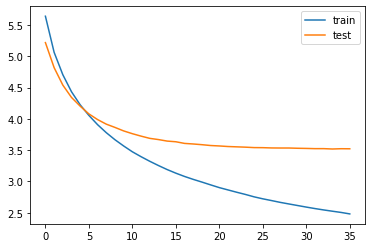

In [43]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

#### 인퍼런스 모델 구현하기
테스트 단계에서는 정수 인덱스 행렬로 존재하던 텍스트 데이터를 실제 데이터로 복원해야 하므로, 필요한 3개의 사전을 아래와 같이 미리 준비해두자.

In [44]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

seq2seq는 훈련할 때와 실제 동작할 때(인퍼런스 단계)의 방식이 다르므로 그에 맞게 모델 설계를 별개로 진행해야 한다.

훈련 단계에서는 디코더의 입력부에 정답이 되는 문장 전체를 한꺼번에 넣고 디코더의 출력과 한번에 비교할 수 있으므로, 인코더와 디코더를 엮은 통짜 모델 하나만 준비했다.

그러나 정답 문장이 없는 인퍼런스 단계에서는 만들어야 할 문장의 길이만큼 디코더가 반복 구조로 동작해야 하기 때문에 부득이하게 인퍼런스를 위한 모델 설계를 별도로 해주어야 한다. 이때는 인코더 모델과 디코더 모델을 분리해서 설계한다.

In [45]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)
# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

어텐션 메커니즘을 사용하는 출력층을 설계하자.

In [46]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

인퍼런스 단계에서 단어 시퀀스를 완성하는 함수를 만들자.

In [47]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if(sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

#### 모델 테스트하기
---
테스트 단계에서는 정수 시퀀스를 텍스트 시퀀스로 변환하여 결과를 확인하는 것이 편할 것이다. 주어진 정수 시퀀스를 텍스트 시퀀스로 변환하는 함수를 만들어보자. 함수를 만들 때, Text의 정수 시퀀스에서는 패딩을 위해 사용되는 숫자 0을 제외시키고 Summary의 정수 시퀀스에서는 숫자 0, 시작 토큰의 인덱스, 종료 토큰의 인덱스를 출력에서 제외시키도록 만들것이다.

In [48]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if(i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

### Step 4. 실제 결과와 요약문 비교하기 (추상적 요약)
---
원래의 요약문(headlines 열)과 학습을 통해 얻은 추상적 요약의 결과를 비교해보자.

In [49]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : government thursday said proposal reconsider decision air india privatisation also said ban direct recruitment air india non operational categories employees total number regular employees air india november approximately august 
실제 요약 : no proposal to air india privatisation govt 
예측 요약 :  air india privatisation privatisation of privatisation govt


원문 : bengaluru based biotech startup technologies raised million series funding flipkart co founder binny bansal indian angel network individual investors according filings startup already received million remaining amount come tranches founded startup focusses tissue engineering medicine 
실제 요약 : flipkart co founder backs startup 
예측 요약 :  bengaluru based startup raises mn from softbank


원문 : bangladesh captain shakib al hasan surpassed legendary english cricketer ian become fastest cricketer history test cricket complete double wickets runs shakib achieved feat th test one less long standing record shakib picked combined total fiv

예측 요약 :  haryana police to give funds for kerala flood victims


원문 : turkish president recep tayyip erdo monday said us embarked false path solving political problems negotiations language blackmail threats slamming us sanctioning turkey erdo added us lost credibility engaging trade war world 
실제 요약 : us on false path of problems through threats turkey 
예측 요약 :  turkish prez calls for political eu


원문 : talking sexually harassed pitch perfect actress rebel wilson revealed male star asked repeatedly stick finger male friends tried film incident added whole thing disgusting told people industry story graphic detail warn individual 
실제 요약 : male star friends tried to film him harassing me rebel 
예측 요약 :  was told to do not wear sex abuse accused prof


원문 : rti query revealed unknown ordered four month internet shutdown kashmir last year hizbul mujahideen commander burhan wani death rti query sought order state home department forwarded divisional commissioner saying subject matter info

예측 요약 :  bihar girl gets record for paper paper in days


원문 : ajit jogi first cm chhattisgarh said team bjp would contest assembly elections incumbent cm raman singh rajnandgaon constituency jogi earlier member congress broke away form party chhattisgarh janata congress called congress irrelevant saying closed chapter 
실제 요약 : am not team of bjp in chhattisgarh elections ajit 
예측 요약 :  chhattisgarh cm vajpayee will contest polls in assembly polls


원문 : us national security advisor john bolton said north korea send dismantled nuclear weapons us lab sanctions eased regime sanctions imposed response north korea nuclear ballistic missiles programme north korea said dismantle nuclear test site ceremony may 
실제 요약 : send nukes to us for sanctions us to korea 
예측 요약 :  korea will korean nuke program us


원문 : television actress saumya tandon reportedly planning quit television serial bhabi ji ghar par hai focus projects shilpa shinde earlier played bhabhi show claimed saumya taken sexual ha

많은 결과가 출력이 되는데, 기존의 요약과는 다른 요약을 출력하면서도 원문의 내용을 담고 있는 의미있는 요약들이 보인다. 심지어 일부 요약의 경우에는 원문에 없던 단어를 사용해서 요약을 하기도 하고 있다. 워드 임베딩과 RNN의 콜라보로 이뤄낸 신기한 성과인 것이다.

물론 슬프게도 그다지 좋지 않은 요약의 예도 꽤나 보인다 . 성능을 개선하기 위해서는 seq2seq와 어텐션의 자체의 조합을 좀 더 좋게 수정하는 방법도 있고, 빔 서치(beam search), 사전 훈련된 워드 임베딩(pre-trained word embedding), 또는 인코더 - 디코더 자체의 구조를 새로이 변경한 하는 트랜스포머(Transformer)와 같은 여러 개선 방안들이 존재한다.

### Step 5. Summa을 이용해서 추출적 요약해보기
---
추상적 요약은 추출적 요약과는 달리 문장의 표현력을 다양하게 가져갈 수 있지만, 추출적 요약에 비해서 난이도가 높다. 반대로 말하면 추출적 요약은 추상적 요약에 비해 난이도가 낮고 기존 문장에서 문장을 꺼내오는 것이므로 잘못된 요약이 나올 가능성이 낮다.

Summa의 summarize를 사용하여 추출적 요약을 해보자.

#### 패키지 설치
---
먼저 필요한 패키지를 아래와 같이 설치하자.

```bash
$ pip install summa
```

#### 데이터 다운로드하기
---

In [50]:
import requests
from summa.summarizer import summarize

전처리 하지 않은 `data2`를 준비한다. `data2`는 `Text` 칼럼만 사용한다.

In [51]:
data2.head()

0    Saurav Kant, an alumnus of upGrad and IIIT-B's...
1    Kunal Shah's credit card bill payment platform...
2    New Zealand defeated India by 8 wickets in the...
3    With Aegon Life iTerm Insurance plan, customer...
4    Speaking about the sexual harassment allegatio...
Name: Text, dtype: object

`data2`에는 매트릭스 시놉시스가 문자열로 저장되어져 있다. 출력 결과가 아주 길기 때문에 일부만 출력해보고, 잘 저장이 되었는지 확인해보자.

In [52]:
print(data2[2])

New Zealand defeated India by 8 wickets in the fourth ODI at Hamilton on Thursday to win their first match of the five-match ODI series. India lost an international match under Rohit Sharma's captaincy after 12 consecutive victories dating back to March 2018. The match witnessed India getting all out for 92, their seventh lowest total in ODI cricket history.


#### summarize 사용하기
---
Summa의 `summarize()`의 인자로 사용되는 값들에 대해서 알아보자.

* __text (str)__ : 요약할 테스트.
* __ratio (float, optional)__ – 요약문에서 원본에서 선택되는 문장 비율. 0~1 사이값
* __words (int or None, optional)__ – 출력에 포함할 단어 수.
* 만약, ratio와 함께 두 파라미터가 모두 제공되는 경우 ratio는 무시한다.
* __split (bool, optional)__ – True면 문장 list / False는 조인(join)된 문자열을 반환

Summa의 summarize는 문장 토큰화를 별도로 하지 않더라도 내부적으로 문장 토큰화를 수행한다. 그렇기 때문에 문장 구분이 되어있지 않은 원문을 바로 입력으로 넣을 수 있다. 10, 20, 30, 40, 50 개의 단어수 순으로 출력해보자.

In [53]:
print('Summary:')
print(summarize(data2[1], words=10))

Summary:



In [54]:
print('Summary:')
print(summarize(data2[1], words=20))

Summary:
Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.


In [55]:
print('Summary:')
print(summarize(data2[1], words=30))

Summary:
Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.


In [56]:
print('Summary:')
print(summarize(data2[1], words=40))

Summary:
Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins.
Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.


In [57]:
print('Summary:')
print(summarize(data2[1], words=50))

Summary:
Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year.
Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins.
Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.


* 10개는 출력되지 않았고,
* 20, 30개가 요약문으로는 적당해보인다.
* 40, 50개는 요약으로는 좀 길다.

따라서 출력 단어수를 25개로 정했다.

#### words=25개로 추출적 요약하기.
---

In [58]:
for i in range(78000, 78100):
    print('Summary:')
    print(summarize(data2[i], words=20))

Summary:
Prime Minister Narendra Modi said during his radio programme 'Mann ki Baat' that GST has transformed the economy, adding that it ushers in a new culture.
Summary:
The picture was originally shared on CRPF's official Twitter account, with the caption 'Brothers-in-arms for peace'.
Summary:
She said that in "some of the developed countries like the US, marijuana has been legalised, which ultimately results in less drug abuse".
Summary:
Inspection of the iPhone showed remnants of internal shorting, states the lawsuit.
Summary:
A newly-launched journal named 'The California Review of Images and Mark Zuckerberg' has offered about Ã¢ÂÂ¹20,000 to authors to analyse and write essays on specific photos of Facebook CEO Mark Zuckerberg.
Summary:
Chinese bike-sharing startup Ofo has been sued for Ã¢ÂÂ¹8.3 crore after an 11-year-old boy died in an accident while riding its bike.
Summary:
Designer Anita Dongre paid a tribute to Rajasthan's Bishnoi community through her collection 'Tree of 

### Step 6. 추상적 요약과 추출적 요약 비교
---
추상적 요약은 전저치 과정을 거쳤기 때문에 추출적 요약 인덱스와 다르다. 그래서 핵심단어로 같은 인덱스를 찾아야 한다.

In [105]:
decode_sequence(encoder_input_test[1].reshape(1, text_max_len))

' twinkle khanna was still my career twinkle'

In [106]:
seq2text(encoder_input_test[1])

'actress turned author twinkle khanna said husband actor akshay kumar lets win battle words back home think lets win probably diplomatic answer added couple got married completed years marriage january year '

#### 핵심 단어로 동일한 인덱스 찾기
---
`khanna`를 핵심단어로 정했다. data2에서 검색하여 확인하자.

In [109]:
khanna=[]

for i in range(77000, 90000):
    if 'khanna' in data2[i]:
        print(i)
        khanna.append(i)
        
for j in khanna:
    print(data2[int(j)])
    print("\n")

아무것도 나오지 않았다. 코드상의 문제는 없다. 왜 안나오나 고민하고 구글링 하던중...

<img src="./image/khanna.jpg" alt="khanna" />

`khanna`는 지역이름이었다ㅋㅋㅋ

그러니까 첫 글자를 대문자로 검색했어야 했던 것이다. 다시 첫글자를 대문자로 바꾸어서 동일한 문장을 찾아보자.

In [112]:
khanna=[]

for i in range(77000, 98000):
    if 'Khanna' in data2[i]:
        print(i)
        khanna.append(i)
        
for j in khanna:
    print(data2[int(j)])
    print("\n")

77226
77263
77275
79027
79506
79664
79831
79951
81485
81768
81906
82311
82470
82571
82801
83557
83632
83698
83821
85427
85910
85982
86319
86375
86497
86746
87151
87364
87380
87509
88169
88183
88326
88865
88867
88948
89022
89134
89344
89443
89483
89869
90057
90234
90246
90488
90518
90595
90905
90906
90947
90991
91187
91215
91320
91332
91359
91361
91362
91375
91388
91409
91435
91441
91442
91469
91471
91491
91493
91494
91531
91541
92361
92894
93057
93351
94277
94299
94334
94387
94707
94814
94957
95118
95475
95886
96107
96501
96798
96946
97292
97380
97558
97587
97588
Akshay Kumar, while accepting the 'Most Beautiful Man of the Decade' award at Vogue Beauty Awards, revealed his speech was written by his wife Twinkle Khanna. Akshay thanked his "overpaid trainer" and "underpaid cook" for helping him maintain his body. He added credit should go to the fact that he didn't have to carry his two children for nine months.


BCCI's acting president CK Khanna on Thursday said that the board is worki

근데 `Twinkle`이라는 단어랑 계속 같이 나오는 게 이상했다. 그래서 `Twinkle Khanna`를 검색해보니ㅋㅋㅋㅋ 

<img src="./image/twinkle.jpg" alt="Twinkle Khanna" />

사람이었다. 그래서 첫글자가 대문자였던 것이다.

무튼, 같은 text를 찾았다. 97292번에 있었다.

* 추상적 요약 원문(전처리 후)
```
'actress turned author twinkle khanna said husband actor akshay kumar lets win battle words back home think lets win probably diplomatic answer added couple got married completed years marriage january year '
```
* 추출적 요약 원문(전처리 전)
```
Actress-turned-author Twinkle Khanna has said that her husband, actor Akshay Kumar lets her win the battle of words back at home. "I think he lets me win and that's probably the most diplomatic answer," she added. The couple, who got married in 2001, completed 16 years of marriage in January this year.
```

In [123]:
print("실제 요약 :", seq2summary(decoder_input_test[1]))
print("예측 요약 :", decode_sequence(encoder_input_test[1].reshape(1, text_max_len)))
print("추출적 요약 :", summarize(data2[97292], words=25))

실제 요약 : akshay lets me win the battle of words at home twinkle 
예측 요약 :  twinkle khanna was still my career twinkle
추출적 요약 : Actress-turned-author Twinkle Khanna has said that her husband, actor Akshay Kumar lets her win the battle of words back at home.


번역해보자.

* 전처리 전 원문 : 여배우 출신의 작가인 트윙클 칸나는 그녀의 남편인 배우인 아크세이 쿠마르가 그녀가 고향에서 말싸움에서 이기도록 허락했다고 말했다. "저는 그가 제가 이기도록 허락하고 그것이 아마도 가장 외교적 해답이라고 생각합니다,"라고 그녀는 덧붙였다. 2001년 결혼한 이 커플은 올해 1월 결혼 16년을 마쳤다.
* 전처리 된 원문 : 작가로 변신한 배우인 트윙클 칸나는 남편 배우인 아크샤이 쿠마르가 고향에서 전투어를 얻어내 아마도 외교적 해답을 얻도록 생각한다고 말했다.
* 실제 요약 : Akshay는 집에서 하는 말싸움에서 나를 이기게 한다.
* 추상적 요약 : 트윙클 칸나는 여전히 내 직업의 트윙클 칸나는
* 추출적 요약 : 여배우 출신의 작가인 트윙클 칸나는 그녀의 남편인 배우인 아크세이 쿠마르가 그녀가 고향에서 말싸움에서 이기도록 허락했다고 말했다.

### 회고
---
* 추상적요약을 많은 시간과 노력을 들여 힘들게 했지만, 결과가 처첨한 것을 보니 회의김이 들었다.
* 오히려 빠르게 끝난 추출적요약이 성능이 좋았다.
* 추상적요약의 인덱스 순서가 전처리 과정중에 달라져서, 추출적 요약과 함께 출력 비교가 어려웠다. (random 함수 쓰지 않을 걸 그랬다...)

### 루브릭
---
* Abstractive 모델 구성을 위한 텍스트 전처리 단계가 체계적으로 진행되었다.<br>
(_분석단계, 정제단계, 정규화와 불용어 제거, 데이터셋 분리, 인코딩 과정이 빠짐없이 체계적으로 진행되었다._)

    * __분석단계, 정제단계, 정규화, 불용어 제거, 데이터셋 분리, 인코딩 과정을 빠짐없고 정확하게 진행했다.__

* 텍스트 요약모델이 성공적으로 학습되었음을 확인하였다.<br>
( _모델학습이 안정적으로 수렴되었음을 그래프를 통해 확인하였으며, 실제 요약문과 유사한 요약문장을 얻을 수 있었다._)
    
    * __모델학습을 진행하였고, loss값과 val_loss값을 그래프에 그렸으며, 요약문과 유사하게 문장을 얻었다.__

* Extractive 요약을 시도해 보고 Abstractive 요약 결과과 함께 비교해 보았다.<br>
(_두 요약 결과를 문법완성도 측면과 핵심단어 포함 측면으로 나누어 비교분석 결과를 제시하였다._)
    
    * __두 요약 결과를 출력하여 번역을 통해 비교분석 결과를 제시하였다.__